In [1]:
import torch, gc
import os
import torchvision
import torchvision.datasets
import torchvision.transforms as transforms
import torch.utils.data
import torch.nn as nn
import os
import numpy as np
from matplotlib import pyplot as plot
from tqdm import tqdm

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda


## 1. Загрузка данных

In [2]:
# Загрузка набора данных CIFAR
data_transforms = transforms.Compose([
    transforms.Resize(244),#256),
    #transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

train = torchvision.datasets.CIFAR10(
    root='./data',
    train=True,
    download=True,
    transform=data_transforms
)

test = torchvision.datasets.CIFAR10(
    root='./data',
    train=False,
    download=True,
    transform=data_transforms
)

trainloader = torch.utils.data.DataLoader(train, batch_size=50,shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(test, batch_size=50, shuffle=False, num_workers=2)



100%|██████████| 170498071/170498071 [00:03<00:00, 43330133.58it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [4]:
print(' Размер обучающей выборки', len(train), '\n', 'Размер тестовой выборки', len(test))

 Размер обучающей выборки 50000 
 Размер тестовой выборки 10000


* Визуализация датасета

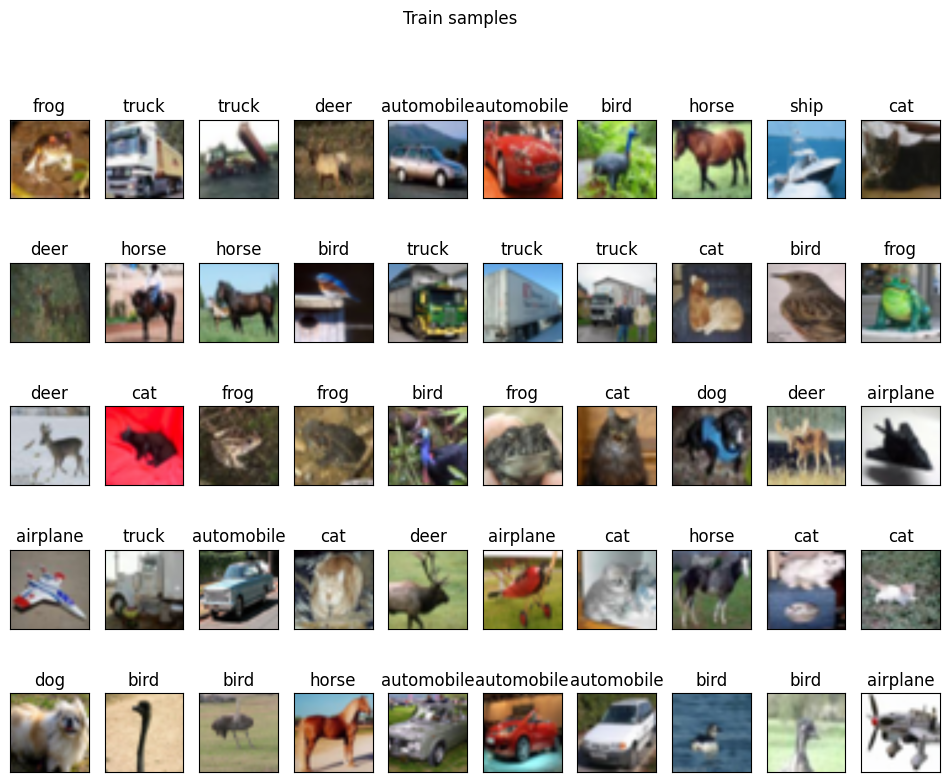

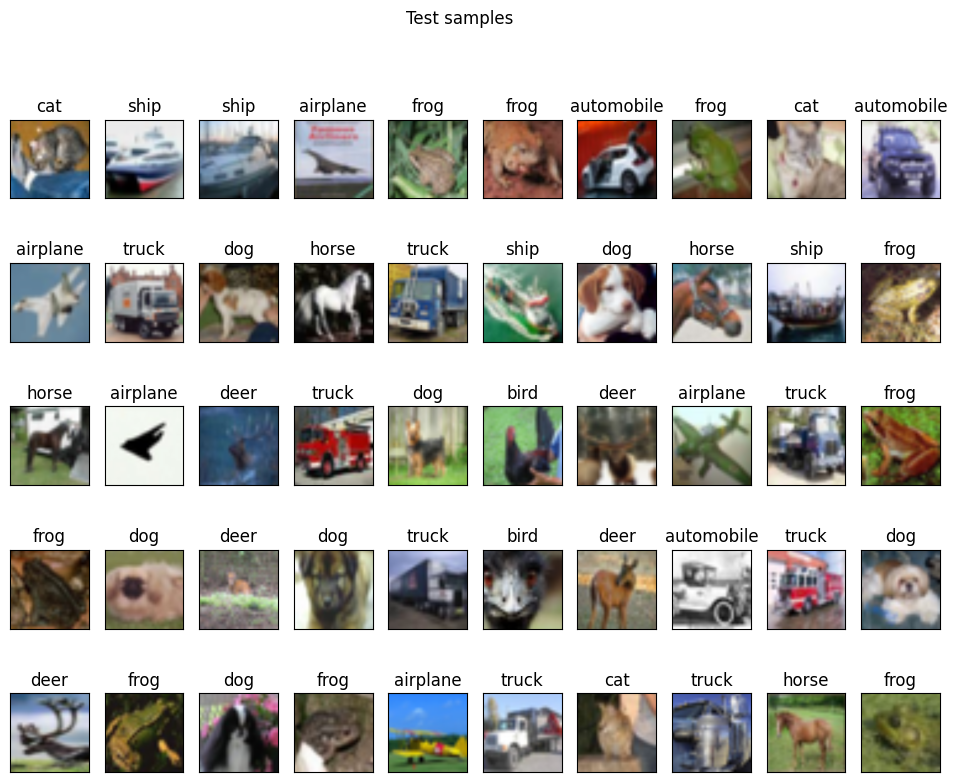

In [5]:
# Метки классов
classes={0: 'airplane', 1: 'automobile', 2:'bird', 3:'cat', 4:'deer', 5:'dog', 6:'frog', 7:'horse', 8:'ship', 9:'truck'}

def show_images(images, title):
    num_showed_imgs_x = 10
    num_showed_imgs_y = 5

    figsize = (12, 9)
    fig, axes = plot.subplots(num_showed_imgs_y, num_showed_imgs_x, figsize = figsize)
    fig.suptitle(title)
    plot.setp(plot.gcf().get_axes(), xticks = [], yticks = [])
    for i, ax in enumerate(axes.flat):
        img = images[i][0].numpy().transpose(1, 2, 0)
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        img = std * img + mean
        img = np.clip(img, 0, 1)
        ax.set_title(classes[images[i][1]])
        ax.imshow(img)
pass


show_images(train, 'Train samples')
show_images(test, 'Test samples')

In [6]:
# Размер изображения:
test[0][0].shape

torch.Size([3, 244, 244])

##### Предварительно обученную модель AlexNet из библиотеки torchvision с предварительно обученными весами.

In [37]:
model = torchvision.models.alexnet(pretrained=True)

model

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

##### Веса оставляем без заморозки

In [38]:
for param in model.parameters():
    print(param.requires_grad)

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


In [39]:
model.classifier = nn.Linear(model.classifier[1].in_features, 10)
for param in model.parameters():
    print(param.requires_grad)

True
True
True
True
True
True
True
True
True
True
True
True


In [40]:
# Использовать GPU
model = model.cuda()

# В качестве cost function используем кросс-энтропию
loss_fn = nn.CrossEntropyLoss()

# Обучаем только классификатор
optimizer = torch.optim.SGD(model.parameters(), lr=0.005, momentum=0.9)

num_epochs = 10

In [3]:
# Вычисление точности
def get_accuracy(data_loader, model):
    tp = 0
    n = 0
    with torch.no_grad():
        for images, labels in data_loader: # проход по всем данным
            # Получение выхода сети на входном батче
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            n += labels.size(0)
            tp += (predicted == labels).sum() # определение количества корректных совпадений
    return tp / n

def training(trainloader, model, loss_fn, optimizer, num_epochs):
    train_accuracy = []  # список для хранения тренировочной точности
    test_accuracy = []  # список для хранения тестовой точности

    for epoch in tqdm(range(num_epochs)):
        # проход по эпохам
        for i, (images, labels) in enumerate(trainloader):
            # получение batch
            # Загрузка данных на устройство
            images = images.requires_grad_().to(device)
            labels = labels.to(device)

            # Прямой проход
            outputs = model(images)
            loss = loss_fn(outputs, labels)

            # Обратный проход
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # train accuracy по завершении эпохи
        train_acc = get_accuracy(trainloader, model)
        test_acc = get_accuracy(testloader, model)

        train_accuracy.append(train_acc)
        test_accuracy.append(test_acc)

        print('Epoch', epoch, 'train accuracy =', train_acc, 'test accuracy =', test_acc)

In [43]:
training(trainloader, model, loss_fn, optimizer, num_epochs)

 10%|█         | 1/10 [04:21<39:14, 261.56s/it]

Epoch 0 train accuracy = tensor(0.8481, device='cuda:0') test accuracy = tensor(0.8120, device='cuda:0')


 20%|██        | 2/10 [08:32<34:01, 255.22s/it]

Epoch 1 train accuracy = tensor(0.8912, device='cuda:0') test accuracy = tensor(0.8291, device='cuda:0')


 30%|███       | 3/10 [12:40<29:22, 251.84s/it]

Epoch 2 train accuracy = tensor(0.9237, device='cuda:0') test accuracy = tensor(0.8307, device='cuda:0')


 40%|████      | 4/10 [16:48<25:01, 250.33s/it]

Epoch 3 train accuracy = tensor(0.9503, device='cuda:0') test accuracy = tensor(0.8463, device='cuda:0')


 50%|█████     | 5/10 [20:57<20:49, 249.88s/it]

Epoch 4 train accuracy = tensor(0.9508, device='cuda:0') test accuracy = tensor(0.8376, device='cuda:0')


 60%|██████    | 6/10 [25:05<16:37, 249.38s/it]

Epoch 5 train accuracy = tensor(0.9752, device='cuda:0') test accuracy = tensor(0.8593, device='cuda:0')


 70%|███████   | 7/10 [29:14<12:27, 249.21s/it]

Epoch 6 train accuracy = tensor(0.9663, device='cuda:0') test accuracy = tensor(0.8413, device='cuda:0')


 80%|████████  | 8/10 [33:25<08:19, 249.73s/it]

Epoch 7 train accuracy = tensor(0.9739, device='cuda:0') test accuracy = tensor(0.8477, device='cuda:0')


 90%|█████████ | 9/10 [37:34<04:09, 249.50s/it]

Epoch 8 train accuracy = tensor(0.9653, device='cuda:0') test accuracy = tensor(0.8385, device='cuda:0')


100%|██████████| 10/10 [41:42<00:00, 250.30s/it]

Epoch 9 train accuracy = tensor(0.9799, device='cuda:0') test accuracy = tensor(0.8418, device='cuda:0')


In [44]:
print('Test accuracy: {}'.format(get_accuracy(testloader, model)))

Test accuracy: 0.8417999744415283


##### Часть весов замораживаем

In [45]:
model = torchvision.models.alexnet(pretrained=True)

for param in model.parameters():
    param.requires_grad = False

# Заменяем Fully-Connected слой на наш линейный классификатор
model.classifier = nn.Linear(model.classifier[1].in_features, 10)

In [46]:
for param in model.parameters():
    print(param.requires_grad)

False
False
False
False
False
False
False
False
False
False
True
True


In [9]:
# Использовать GPU
model = model.cuda()

# В качестве cost function используем кросс-энтропию
loss_fn = nn.CrossEntropyLoss()

# Обучаем только классификатор
optimizer = torch.optim.SGD(model.parameters(), lr=0.005, momentum=0.9)

num_epochs = 10

In [12]:
# Вычисление точности
def get_accuracy(data_loader, model):
    tp = 0
    n = 0
    with torch.no_grad():
        for images, labels in data_loader: # проход по всем данным
            # Получение выхода сети на входном батче
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            n += labels.size(0)
            tp += (predicted == labels).sum() # определение количества корректных совпадений
    return tp / n

In [10]:
import matplotlib.pyplot as plt


def training(trainloader, model, loss_fn, optimizer, num_epochs):
    train_accuracy = []  # список для хранения тренировочной точности
    test_accuracy = []  # список для хранения тестовой точности

    for epoch in tqdm(range(num_epochs)):
        # проход по эпохам
        for i, (images, labels) in enumerate(trainloader):
            # получение batch
            # Загрузка данных на устройство
            images = images.requires_grad_().to(device)
            labels = labels.to(device)

            # Прямой проход
            outputs = model(images)
            loss = loss_fn(outputs, labels)

            # Обратный проход
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # train accuracy по завершении эпохи
        train_acc = get_accuracy(trainloader, model)
        test_acc = get_accuracy(testloader, model)

        train_accuracy.append(train_acc)
        test_accuracy.append(test_acc)

        print('Epoch', epoch, 'train accuracy =', train_acc, 'test accuracy =', test_acc)
"""
    # отрисовка графика accuracy
    plt.plot(range(num_epochs), train_accuracy, label='Train Accuracy')
    plt.plot(range(num_epochs), test_accuracy, label='Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()"""


"\n    # отрисовка графика accuracy\n    plt.plot(range(num_epochs), train_accuracy, label='Train Accuracy')\n    plt.plot(range(num_epochs), test_accuracy, label='Test Accuracy')\n    plt.xlabel('Epoch')\n    plt.ylabel('Accuracy')\n    plt.legend()\n    plt.show()"

 10%|█         | 1/10 [04:15<38:21, 255.74s/it]

Epoch 0 train accuracy = tensor(0.9755, device='cuda:0') test accuracy = tensor(0.8924, device='cuda:0')


 20%|██        | 2/10 [08:25<33:38, 252.37s/it]

Epoch 1 train accuracy = tensor(0.9814, device='cuda:0') test accuracy = tensor(0.8973, device='cuda:0')


 30%|███       | 3/10 [12:49<30:03, 257.63s/it]

Epoch 2 train accuracy = tensor(0.9746, device='cuda:0') test accuracy = tensor(0.8884, device='cuda:0')


 40%|████      | 4/10 [17:13<26:00, 260.14s/it]

Epoch 3 train accuracy = tensor(0.9801, device='cuda:0') test accuracy = tensor(0.8942, device='cuda:0')


 50%|█████     | 5/10 [21:29<21:33, 258.72s/it]

Epoch 4 train accuracy = tensor(0.9848, device='cuda:0') test accuracy = tensor(0.8980, device='cuda:0')


 60%|██████    | 6/10 [25:46<17:12, 258.08s/it]

Epoch 5 train accuracy = tensor(0.9884, device='cuda:0') test accuracy = tensor(0.9016, device='cuda:0')


 70%|███████   | 7/10 [29:54<12:44, 254.87s/it]

Epoch 6 train accuracy = tensor(0.9861, device='cuda:0') test accuracy = tensor(0.8947, device='cuda:0')


 80%|████████  | 8/10 [34:06<08:27, 253.67s/it]

Epoch 7 train accuracy = tensor(0.9900, device='cuda:0') test accuracy = tensor(0.9024, device='cuda:0')


 90%|█████████ | 9/10 [38:19<04:13, 253.55s/it]

Epoch 8 train accuracy = tensor(0.9911, device='cuda:0') test accuracy = tensor(0.9008, device='cuda:0')


100%|██████████| 10/10 [42:32<00:00, 255.25s/it]

Epoch 9 train accuracy = tensor(0.9901, device='cuda:0') test accuracy = tensor(0.9010, device='cuda:0')


TypeError: ignored

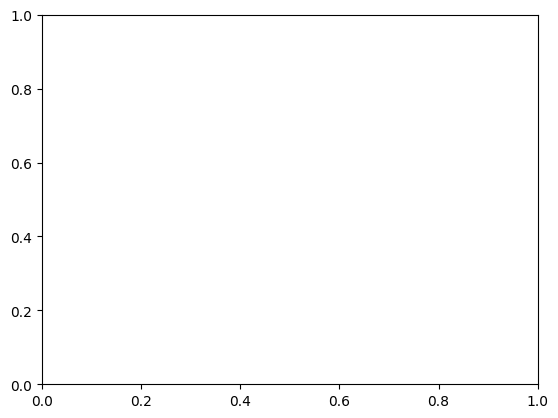

In [19]:
training(trainloader, model, loss_fn, optimizer, num_epochs)

In [20]:
print('Test accuracy: {}'.format(get_accuracy(testloader, model)))

Test accuracy: 0.9009000062942505


# VGG

## VGG Feature Extractor

In [3]:
model = torchvision.models.vgg16(pretrained=True)
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [4]:
for param in model.parameters(): # замораживаем параметры (веса)
    param.requires_grad = False

model.classifier = nn.Linear(model.classifier[0].in_features, 10) # Заменяем Fully-Connected слой на наш линейный классификатор

In [5]:
# Использовать GPU
model = model.cuda()

# В качестве cost function используем кросс-энтропию
loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

num_epochs = 2

In [17]:
training(trainloader, model, loss_fn, optimizer, num_epochs)

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 0 train accuracy = 

 50%|█████     | 1/2 [18:41<18:41, 1121.82s/it]

tensor(0.9720, device='cuda:0') test accuracy = tensor(0.8756, device='cuda:0')
Epoch 1 train accuracy = 

100%|██████████| 2/2 [37:21<00:00, 1120.76s/it]

tensor(0.9810, device='cuda:0') test accuracy = tensor(0.8743, device='cuda:0')


In [18]:
print('VGG16 Test accuracy: {}'.format(get_accuracy(testloader, model)))

VGG16 Test accuracy: 0.8743000030517578


## VGG с другими гиперпараметрами и другим количеством эпох

In [48]:
torch.cuda.empty_cache()
model = torchvision.models.vgg16(pretrained=True)

In [ ]:
# Заменяем Fully-Connected слой на наш линейный классификатор
model.classifier = nn.Linear(model.classifier[0].in_features, 10)

model = model.cuda()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
num_epochs = 4
training(trainloader, model, loss_fn, optimizer, num_epochs)
print('VGG16 Test accuracy: {}'.format(get_accuracy(testloader, model)))

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 0 train accuracy = 

 25%|██▌       | 1/4 [28:21<1:25:05, 1701.76s/it]

tensor(0.8648, device='cuda:0') test accuracy = tensor(0.8325, device='cuda:0')


 50%|█████     | 2/4 [56:41<56:41, 1700.73s/it]  

Epoch 1 train accuracy = tensor(0.9007, device='cuda:0') test accuracy = tensor(0.8438, device='cuda:0')
Epoch 2 train accuracy = tensor(0.9235, device='cuda:0') 

 75%|███████▌  | 3/4 [1:25:01<28:20, 1700.38s/it]

test accuracy = tensor(0.8527, device='cuda:0')


## VGG FineTuning

In [4]:
model = torchvision.models.vgg16(pretrained=True)
model.classifier = nn.Linear(model.classifier[0].in_features, 10)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:05<00:00, 95.4MB/s]


In [5]:
# Использовать GPU
model = model.cuda()

# В качестве cost function используем кросс-энтропию
loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

num_epochs = 2

In [6]:
training(trainloader, model, loss_fn, optimizer, num_epochs)

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 0 train accuracy = 

 50%|█████     | 1/2 [23:04<23:04, 1384.39s/it]

tensor(0.9437, device='cuda:0') test accuracy = tensor(0.8902, device='cuda:0')
Epoch 1 train accuracy = 

100%|██████████| 2/2 [46:07<00:00, 1383.88s/it]

tensor(0.9779, device='cuda:0') test accuracy = tensor(0.9068, device='cuda:0')


In [7]:
vgg_finetuning_acc = get_accuracy(testloader, model)
print('VGG16 Finetuning Test accuracy: {}'.format(vgg_finetuning_acc))

VGG16 Finetuning Test accuracy: 0.9067999720573425


In [9]:
models_acc_0 = []

models_acc_0.append(vgg_finetuning_acc)
models_acc_0

[tensor(0.9068, device='cuda:0')]

# EfficientNet

In [10]:
model = torchvision.models.efficientnet_v2_s(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_V2_S_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_V2_S_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_v2_s-dd5fe13b.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_v2_s-dd5fe13b.pth
100%|██████████| 82.7M/82.7M [00:00<00:00, 104MB/s]


In [ ]:
# замораживаем параметры (веса)
for param in model.parameters():
    param.requires_grad = False

# Заменяем Fully-Connected слой на наш линейный классификатор
model.classifier = nn.Linear(model.classifier[1].in_features, 10)

# Использовать GPU
model = model.cuda()

In [ ]:
# Использовать GPU
#model = model.cuda()

# В качестве cost function используем кросс-энтропию
loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

num_epochs = 5

In [ ]:
torch.cuda.empty_cache()

In [ ]:
training(trainloader, model, loss_fn, optimizer, num_epochs)

In [ ]:
eff_fe = get_accuracy(testloader, model)
print('EfficintNet Feature Extractor Test accuracy: {}'.format(eff_fe))

In [ ]:
model = torchvision.models.efficientnet_v2_s(pretrained=True)
model = model.cuda()

In [ ]:
loss_fn = nn.CrossEntropyLoss()

# Обучаем только классификатор
#optimizer = torch.optim.Adam(model.classifier.parameters(), lr=1e-4)
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
# Умножает learning_rate на 0.1 каждые 7 эпох (это одна из эвристик, не было на лекциях)
#exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

num_epochs = 5

In [ ]:
training(trainloader, model, loss_fn, optimizer, num_epochs)

In [ ]:

for epoch in tqdm(range(num_epochs)):  # проход по эпохам
    for i, (images, labels) in enumerate(trainloader): # получение batch
        # Загрузка данных на устройство
        images = images.requires_grad_().to(device)
        labels = labels.to(device)
        # Прямой проход
        outputs = model(images)
        loss = loss_fn(outputs, labels)
        # Обратный проход
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # train accuracy по завершении эпохи
    print('Epoch[{}]: train accuracy = {}'.
          format(epoch, get_accuracy(trainloader, model)))

In [ ]:
print('Test accuracy: {}'.format(get_accuracy(testloader, model)))

## 2. Построение архитектуры сверточной сети

In [ ]:
class ConvolutionalNeuralNetwork(nn.Module):
    def __init__(self):
        super(ConvolutionalNeuralNetwork, self).__init__()
        self.conv1 = nn.Sequential(
            # Свертка. Размер результирующей карты признаков:
            # 8 x ((32-3)/1+1) x ((32-3)/1+1) = 8 x 30 x 30
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3, stride = 1),
            # Batch Normalization и ReLU. Размер результирующей карты признаков 8 X 30 X 30
            nn.BatchNorm2d(8),
            nn.ReLU(),
            # Пространственное объединение по максимуму. Размер результирующей карты признаков:
            # 8 x ((30-2)/1+1) x ((30-2)/1+1) = 8 x 29 x 29
            nn.MaxPool2d(kernel_size=2, stride = 1)
        )
        self.conv2 = nn.Sequential(
            # Свертка. Размер результирующей карты признаков:
            # 16 x ((29-3)/1+1) x ((29-3)/1+1) = 16 x 27 x 27
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, stride = 1),
            # Batch Normalization и ReLU. Размер результирующей карты признаков 16 X 27 X 27
            nn.BatchNorm2d(16),
            nn.ReLU(),
            # Пространственное объединение по максимуму. Размер результирующей карты признаков:
            # 16 x ((27-2)/1+1) x ((27-2)/1+1) = 16 x 26 x 26
            nn.MaxPool2d(kernel_size=2, stride = 1)
        )
        self.conv3 = nn.Sequential(
            # Свертка. Размер результирующей карты признаков:
            # 32 x ((26-3)/1+1) x ((26-3)/1+1) = 32 x 24 x 24
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride = 1),
            # Batch Normalization и ReLU. Размер результирующей карты признаков 32 X 24 X 24
            nn.BatchNorm2d(32),
            nn.ReLU(),
            # Пространственное объединение по максимуму. Размер результирующей карты признаков:
            # 32 x ((24-2)/1+1) x ((24-2)/1+1) = 32 x 23 x 23
            nn.MaxPool2d(kernel_size=2, stride = 1)
        )
        # Полносвязные слои
        self.lin1 = nn.Linear(32 * 23 * 23, 100)
        self.lin2 = nn.Linear(100, 80)
        self.out = nn.Linear(80, 10)

    # Переопределение метода, вызываемого в процессе прямого прохода
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)

        x = x.view(x.size(0), -1)
        x = nn.ReLU()(self.lin1(x))
        x = nn.ReLU()(self.lin2(x))
        out = self.out(x)
        return out

In [ ]:
import torchsummary
cnn_model = ConvolutionalNeuralNetwork()
torchsummary.summary(cnn_model.cuda(), (3, 32, 32))

## 3. Обучение модели

In [ ]:
from tqdm import tqdm

In [ ]:
# Обучение построенной модели на GPU

num_epochs = 20 # количество эпох

# Выбор устройства для вычислений
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
cnn_model.to(device)
# Функция ошибки на этапе обучения
loss_function = torch.nn.CrossEntropyLoss()
# Метод оптимизации для обучения параметров
optimizer = torch.optim.SGD(cnn_model.parameters(), lr=0.001, momentum=0.9)

Параметры алгоритма обучения:

In [ ]:
print(optimizer)

In [ ]:
# Вычисление точности
def get_accuracy(data_loader, model):
    tp = 0
    n = 0
    with torch.no_grad():
        for images, labels in data_loader: # проход по всем данным
            # Получение выхода сети на входном батче
            images = images.to(device)
            labels = labels.to(device)
            outputs = cnn_model(images)
            _, predicted = torch.max(outputs.data, 1)
            n += labels.size(0)
            tp += (predicted == labels).sum() # определение количества корректных совпадений
    return tp / n

for epoch in tqdm(range(num_epochs)):  # проход по эпохам
    for i, (images, labels) in enumerate(trainloader): # получение batch
        # Загрузка данных на устройство
        images = images.requires_grad_().to(device)
        labels = labels.to(device)
        # Прямой проход
        outputs = cnn_model(images)
        loss = loss_function(outputs, labels)
        # Обратный проход
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # train accuracy по завершении эпохи
    print('Epoch[{}]: train accuracy = {}'.
          format(epoch, get_accuracy(trainloader, cnn_model)))

*  tqdm info: training time = 5:01 (GPU)

## 4. Тестирование модели

In [ ]:
# Тестирование обученной модели

# Логирование метрики качества на тренировочных данных
print('Test accuracy: {}'.format(get_accuracy(testloader, cnn_model)))

In [ ]:
import time
# Продублируем проход по данным, чтобы не включать дополнительные факторы во время классификации
t = []
with torch.no_grad():
    for images, labels in testloader: # проход по всем данным
        # Получение выхода сети на входной пачке изображений
        images = images.to(device)
        labels = labels.to(device)
        st = time.time()
        outputs = cnn_model(images)
        _, predicted = torch.max(outputs.data, 1)
        fin = time.time()
        t.append(fin - st)

av_t = np.array(t).sum() / len(t)
print('Average classification time (GPU): ', np.around(av_t, 3))